# Loan Cutomer Behavior

**Source:** Kaggle (https://www.kaggle.com/datasets/subhamjain/loan-prediction-based-on-customer-behavior)
**Author of solution:** Ilan Grynszpan

### Summary:

1. Imports
2. Read and summarize data
3. Data cleaning
4. Exploratory data analysis
5. Modelling

## Imports

In [112]:
import pandas as pd
import numpy as np

## visuals
import seaborn as sns
import matplotlib.pyplot as plt

## aux
import os
import warnings
warnings.filterwarnings("ignore")

## statistics
import scipy.stats as stats

## ML
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

## Read and summarize data

In [48]:
BASE_DIR = "data"
print(os.listdir(BASE_DIR))
dataframes = [pd.read_csv(os.path.join(BASE_DIR, df)) for df in os.listdir(BASE_DIR)]

['Sample Prediction Dataset.csv', 'Test Data.csv', 'Training Data.csv']


In [49]:
train_data = dataframes[2]
test_data = dataframes[1]

### summarize and test for null values

In [50]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


In [51]:
train_data.isnull().sum()

Id                   0
Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

In [52]:
train_data.describe()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,252000.000000,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,126000.500000,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,72746.278255,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.000000,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,63000.750000,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,126000.500000,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,189000.250000,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,252000.000000,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


We will just finally check for the possibility of duplicates in our ids and in our data as a general.

In [53]:
all_cols_duplicated = train_data.duplicated().sum()
all_cols_duplicated

0

In [54]:
duplicated_ids = train_data.Id.duplicated().sum()
duplicated_ids

0

There is no duplicated data that we will have to deal with.

Looks like there is no need for data cleaning

### Exploratory data analysis

Hypothesis 1: People who are between 30 and 60 have the lowest risk of defaulting.

In [55]:
H1 = train_data[['Age', 'Risk_Flag']]

In [56]:
## Dividing age between groups of 10 years

bins = [ten for ten in range(20,90,10)]
age_groups = pd.cut(H1.Age, bins=bins, labels=bins[:-1], right=False)
H1['age_group'] = age_groups
H1

,Age,Risk_Flag,age_group
0,23,0,20
1,40,0,40
2,66,0,60
3,41,1,40
4,47,1,40
...,...,...,...
251995,43,0,40
251996,26,0,20
251997,46,0,40
251998,45,0,40


In [57]:
risk_by_age_group = H1[['age_group','Risk_Flag']]\
    .groupby('age_group')\
        .agg({"Risk_Flag":'mean', "age_group":'size'})\
            .rename(columns={'Risk_Flag':'risk','age_group':'size'})\
                .reset_index()\
                    .sort_values('age_group')
risk_by_age_group

,age_group,risk,size
0,20,0.146189,39189
1,30,0.122007,41727
2,40,0.117194,43108
3,50,0.120675,42660
4,60,0.115862,43569
5,70,0.118044,41747


[]

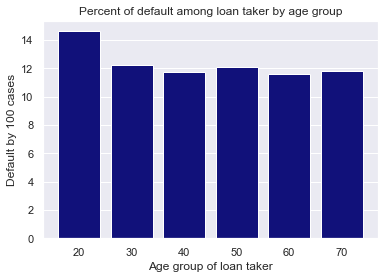

In [58]:
sns.set_theme()

fig = sns.barplot(
    x = risk_by_age_group.age_group,
    y = 100*(risk_by_age_group.risk),
    color = "darkblue"
)

fig.set(
    xlabel='Age group of loan taker', 
    ylabel='Default by 100 cases', 
    title = "Percent of default among loan taker by age group")
plt.plot()

We can perform a proper hypothesis testing:

In [59]:
# first we should divide data between the groups that interest us

age_group_20 = H1[H1['age_group'] == 20]
age_group_between_30_and_60 = H1[(H1['age_group'] >= 30) \
    & (H1['age_group'] < 60)]
age_group_over_60 = H1[H1['age_group'] >= 60]

In [60]:
# Sequence of Bernoulli trials can be approximated by normal distributions when sample is large

age_group_20_desc = {
    'mean':age_group_20['Risk_Flag'].mean(), 
    'var':(age_group_20['Risk_Flag'].mean())*(1 - age_group_20['Risk_Flag'].mean()),
    'size':len(age_group_20)
}

age_group_between_30_and_60_desc = {
    'mean':age_group_between_30_and_60['Risk_Flag'].mean(), 
    'var':(age_group_between_30_and_60['Risk_Flag'].mean())*\
        (1 - age_group_between_30_and_60['Risk_Flag'].mean()),
    'size':len(age_group_between_30_and_60)
}

age_group_over_60_desc = {
    'mean':age_group_over_60['Risk_Flag'].mean(), 
    'var':(age_group_over_60['Risk_Flag'].mean())*(1 - age_group_over_60['Risk_Flag'].mean()),
    'size':len(age_group_over_60)
}

In [61]:
age_group_20_desc['size']

39189

*Method imported from https://www.statology.org/f-test-python/*

In [62]:
#define F-test function
def f_test(x, y):
    f = x['var']/y['var'] #calculate F test statistic 
    dfn = x['size']-1 #define degrees of freedom numerator 
    dfd = y['size']-1 #define degrees of freedom denominator 
    p = 1-stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

In [63]:
f1 = f_test(age_group_20_desc, age_group_between_30_and_60_desc)
f2 = f_test(age_group_between_30_and_60_desc, age_group_over_60_desc)

(f1,f2)

((1.1825471737507238, 1.1102230246251565e-16),
 (1.0222022582267043, 0.0002261788399537945))

The p-value is very low for both cases, which allows us to say that the distributions have equal variance and we can perform a t-test.

In [64]:
normal1 = np.random.normal(loc=age_group_20_desc['mean'],\
     scale=np.sqrt(age_group_20_desc['var']),\
        size=(1000))

normal2 = np.random.normal(loc=age_group_between_30_and_60_desc['mean'],\
     scale=np.sqrt(age_group_between_30_and_60_desc['var']),\
        size=(1000))

normal3 = np.random.normal(loc=age_group_over_60_desc['mean'],\
     scale=np.sqrt(age_group_over_60_desc['var']),\
        size=(1000))


[]

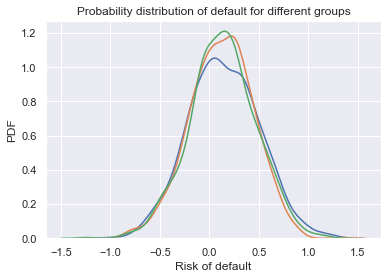

In [65]:
fig, ax = plt.subplots()

p1 = sns.distplot(normal1, hist=False)
p2 = sns.distplot(normal2, hist=False)
p3 = sns.distplot(normal3, hist=False)

ax.set(xlabel='Risk of default', ylabel='PDF', title = "Probability distribution of default for different groups")
plt.plot()

In [66]:
t1 = stats.ttest_ind(normal3, normal2)
t2 = stats.ttest_ind(normal1, normal2)
print(t1, "\n", t2)

Ttest_indResult(statistic=0.8136572480049866, pvalue=0.4159382850172354) 
 Ttest_indResult(statistic=1.598459009847091, pvalue=0.1100989778767241)


The p-value is higher than the threshold of 0.05, therefore we cannot reject the null hypothesis that the risk is any different for different age groups.

** Hypothesis 1 is false. The risk is indeed higher in the group between 20 and 30 years old, but is quite similar among the other age groups, being slightly higher among peolle who are between 30 and 40 or between 50 and 60 years old.**

Hypothesis 2: People who have more work experience have less risk

In [67]:
H2 = train_data[['Experience', 'Risk_Flag']]

In [68]:
H2_exp_risk = H2.groupby('Experience')\
    .agg(['size', 'mean'])\
        .reset_index()\
            .rename(columns = {'Risk_Flag':"default risk"})\
                .sort_values('Experience')

[]

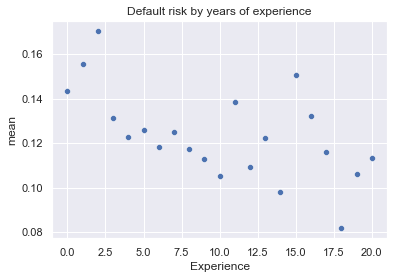

In [69]:
fig, ax = plt.subplots()

plot = sns.scatterplot(x = H2_exp_risk['Experience'],\
    y = H2_exp_risk['default risk']['mean'])

ax.set(title = "Default risk by years of experience")
plt.plot()

We should also check the mean occurence of default by years of experience:

[]

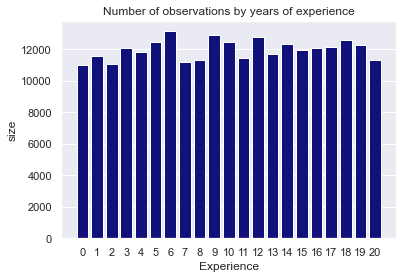

In [70]:
fig, ax = plt.subplots()

plot = sns.barplot(x = H2_exp_risk['Experience'],\
    y = H2_exp_risk['default risk']['size'],
    color = "darkblue")

ax.set(title = "Number of observations by years of experience")
plt.plot()

The distribution of observations by years of experience appears to be the same

The risk appears to be lower as we see an increase in experience. We can test this further by performing a Pearson correlation test.

In [71]:
corr_test = stats.pearsonr(H2_exp_risk['Experience'], H2_exp_risk['default risk']['mean'])
print("Correlation coeficient = {0} for a p-value of {1}".format(corr_test[0], corr_test[1]))

Correlation coeficient = -0.5786837665345279 for a p-value of 0.005989081510197051


It is not a particularly strong correlation, but, as expected, we have a negative correlation which is closer to -1 than to 0 with a p-value < 0.05. **This means that we can accept hypothesis 2, but knowing that the correlation is not extremely strong**.

We could be running other hypothesis, but it appears that a combination of factors will better determine if our client will default or not, so we should explore the relationship that each independent variable has with our target variable.

#### Exploring relationships between variables:

First, we should look at the numeric variables and how their values influence the distribution of defaulting individuals.

In [72]:
features = train_data.drop(['Id', 'Risk_Flag'], axis=1)
target = train_data['Risk_Flag']
numeric_train_data = features.select_dtypes(include=np.number)

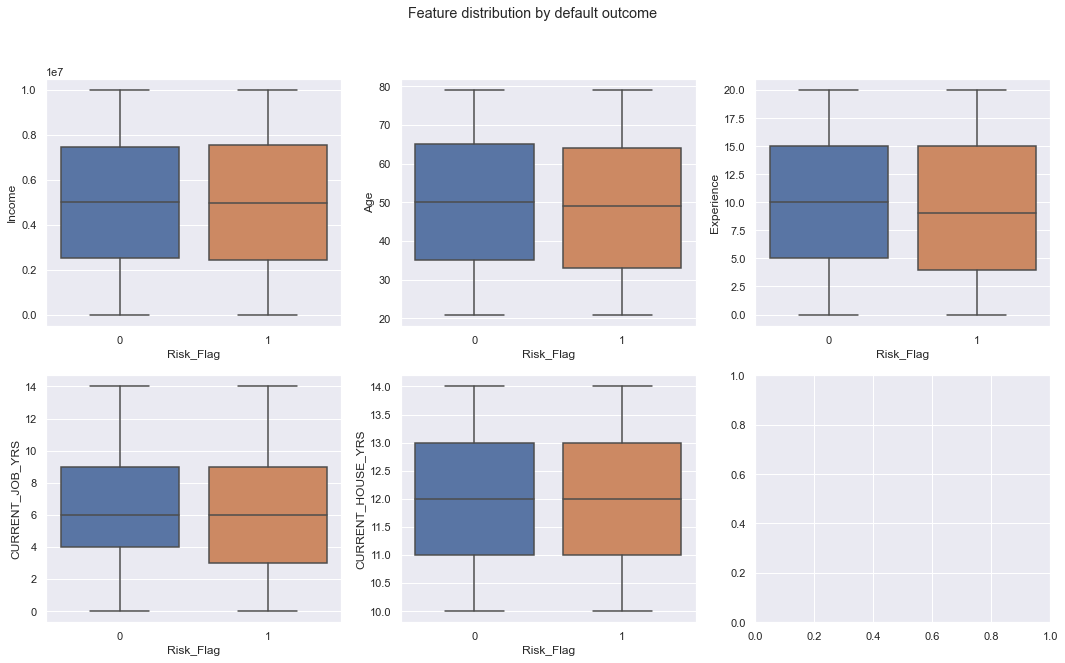

In [73]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(18, 10))

fig.suptitle('Feature distribution by default outcome')

row = 0
col = 0
for feature_number in range(0, len(numeric_train_data.columns)):
    if (feature_number + 1) % 4 == 0:
        row += 1
        col = 0
    sns.boxplot(
        ax = ax[row, col], 
        data = train_data, 
        x = "Risk_Flag", 
        y = numeric_train_data.columns[feature_number]
        )
    col += 1

In [109]:
train_data.groupby('Risk_Flag').mean().drop('Id', axis=1)

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
Risk_Flag,,,,,
0,5.000449e+06,50.093442,10.162042,6.357016,12.000086
1,4.973359e+06,48.960350,9.531101,6.168893,11.981449


It appears that values are, in average, smaller for defaulting individuals. Distributions do not have a lot of outliers. The exception to this rule is CURRENT_HOUSE_YRS.

We should investigate possible correlation between numeric features

<AxesSubplot:>

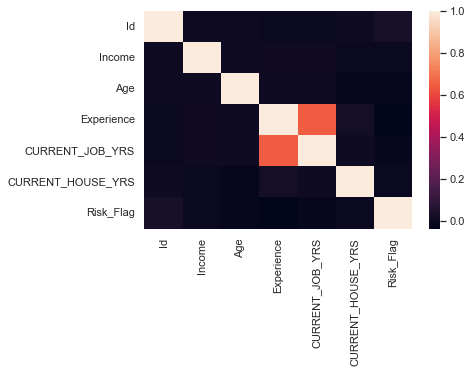

In [111]:
num_corr_data = train_data.corr()
sns.heatmap(num_corr_data)

### Preparing data for modelling

Dealing with data unbalancing

In [117]:
target = train_data['Risk_Flag']
target.value_counts(normalize = True)

0    0.877
1    0.123
Name: Risk_Flag, dtype: float64

In [118]:
target.value_counts()

0    221004
1     30996
Name: Risk_Flag, dtype: int64

Data is unbalanced. Since we have 30k observations on the samller class, we are safe to downsample.

In [114]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop('Risk_Flag', axis=1),
    train_data['Risk_Flag'], 
    test_size=0.33, 
    random_state=1
    )